In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

In [2]:
orig_data_25= pd.read_csv('data_25.csv')
orig_data_30= pd.read_csv('data_30.csv')
full=pd.merge(orig_data_25, orig_data_30, on=['state','location','year','plot','n_rate_fall','n_rate_spring'])
full_all= pd.merge(orig_data_25, orig_data_30, on=['state','location','plot','n_rate_fall','n_rate_spring'])

In [3]:
stamp= orig_data_25.columns[4:5].tolist()
cols_25= [column for column in full.columns if '25' in column]
cols_30= [column for column in full.columns if '30' in column]
cols_60= ['shoot_n_kg_ha_60', 'biomass_60']

In [4]:
data_25= orig_data_25[stamp+cols_25]
data_30= orig_data_30[stamp+cols_30]

In [5]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings(action='ignore')

In [11]:
# Encoding the 25-feature data --- one approach
# --- old version: feats_to_encode= OneHotEncoder(categorical_features=[0])
# --- feats_to_encode= OneHotEncoder(n_features= [0])
feats_to_encode= OneHotEncoder()
feats_25= feats_to_encode.fit_transform(data_25).toarray()

# Encoding the 30-feature data --- another approach
n_labels_bin= OneHotEncoder()
n_rates= data_30.n_rate_fall.values.reshape(-1,1)
n_labels= n_labels_bin.fit_transform(n_rates)
feats_30= np.hstack((n_labels.toarray(), data_30.iloc[:,1:].values))

In [19]:
# Prepare samples
y_25= orig_data_25.biomass_60.values
y_30= orig_data_30.biomass_60.values
X_25_train, X_25_test, y_25_train, y_25_test= train_test_split(feats_25, y_25, test_size=.30, random_state= 42)
X_30_train, X_30_test, y_30_train, y_30_test= train_test_split(feats_30, y_30, test_size=.30, random_state= 42)

In [8]:
# Instatiate model:
rf_model= rf(random_state= 42, n_estimators= 600, min_samples_split=3)
ridge= Ridge(alpha= 3.0)
lasso= Lasso(alpha= 3.0)
lm= LinearRegression()

In [9]:
def train_test_model(stage, model=lm):
    if stage == '25':
        model= model.fit(X_25_train, y_25_train)
        preds_train= model.predict(X_25_train)
        preds_test= model.predict(X_25_test)
        rmse_train= mse(preds_train, y_25_train)
        rmse_test= mse(preds_test, y_25_test)
    else:
        model= model.fit(X_30_train, y_30_train)
        preds_train= model.predict(X_30_train)
        preds_test= model.predict(X_30_test)
        rmse_train= mse(preds_train, y_30_train)
        rmse_test= mse(preds_test, y_30_test)
    return pd.DataFrame({'stage {}'.format(stage): [rmse_train, rmse_test]}, index=['train','test'])

In [10]:
results= pd.concat((train_test_model(stage= '25', model= rf_model),
                    train_test_model(stage= '30', model= rf_model)),
                    axis=1)

In [11]:
results.apply(lambda x: np.sqrt(x))

,stage 25,stage 30
train,1004.710875,796.226375
test,2166.990631,2450.895969


In [12]:
data_25.n_rate_fall.unique(), data_30.n_rate_fall.unique()

(array([  0,  30,  60,  90, 120, 180, 150], dtype=int64),
 array([  0,  60, 150,  30,  90], dtype=int64))

# Revising the rye biomass responses to N in the dataset

In [13]:
N_data= full.groupby(['state','location','year','n_rate_fall','n_rate_spring'], as_index=False)['n_soil_base_x'].mean()

In [14]:
full.columns

Index(['state', 'location', 'year', 'plot', 'n_rate_fall', 'n_rate_spring',
       'n_soil_base_x', 'tiller_eff_25', 'biomass_25', 'ndvi_25',
       'shoot_n_kg_ha_25', 'n_eff_25', 'shoot_c_kg_ha_25', 'cn_ratio_25',
       'biomass_60_x', 'shoot_n_60_x', 'shoot_n_kg_ha_60_x', 'shoot_c_60_x',
       'shoot_c_kg_ha_60_x', 'cn_ratio_60_x', 'n_soil_base_y', 'tiller_eff_30',
       'biomass_30', 'ndvi_30', 'shoot_n_kg_ha_30', 'n_eff_30',
       'shoot_c_kg_ha_30', 'cn_ratio_30', 'biomass_60_y', 'shoot_n_60_y',
       'shoot_n_kg_ha_60_y', 'shoot_c_60_y', 'shoot_c_kg_ha_60_y',
       'cn_ratio_60_y'],
      dtype='object')

In [15]:
full.query('state == "PA" & year == 2012').shape

(60, 34)

In [16]:
import seaborn as sns

In [17]:
bm_N= full.groupby(['state','location','n_rate_fall','n_rate_spring'], 
             as_index=False).agg(
    {'biomass_60_y': lambda x: np.mean(x), 
     'n_soil_base_x': lambda x: np.mean(x),
     'shoot_n_kg_ha_60_y': lambda x: np.mean(x)
    }
).assign(
    total_N= lambda data: data.n_rate_fall + data.n_rate_spring + data.n_soil_base_x
)

In [18]:
bm_N.head(3)

,state,location,n_rate_fall,n_rate_spring,biomass_60_y,n_soil_base_x,shoot_n_kg_ha_60_y,total_N
0,MD,Beltsville,0,0,8333.626250,87.65,82.737500,87.65
1,MD,Beltsville,0,30,7602.115625,87.65,80.966125,117.65
2,MD,Beltsville,0,60,9417.565125,87.65,119.760125,147.65


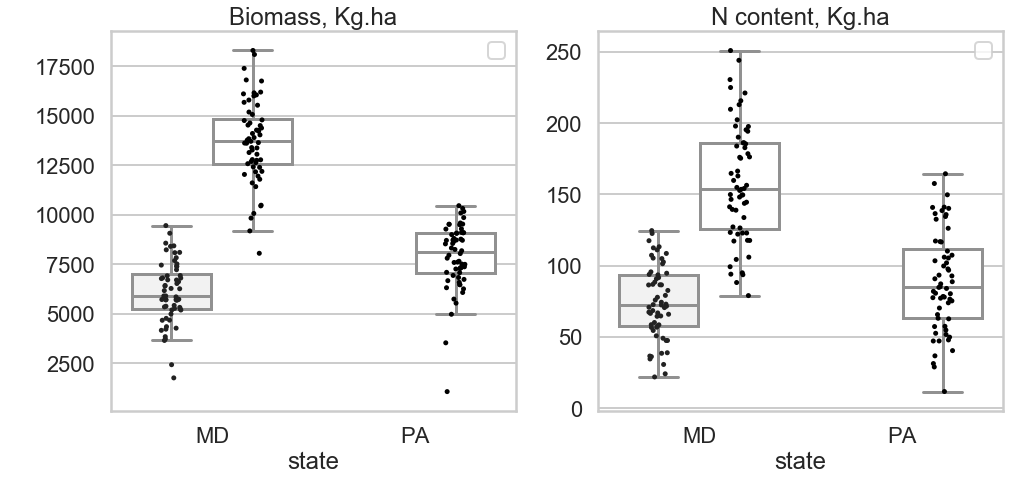

In [19]:
# ---Not print: ------ ###
# Figure 1. Variation of features to predict with statitical learning methods
sns.set_style("whitegrid")
sns.set_context('poster')
f=plt.figure(1, figsize=(16,7))
plt.subplot(1,2,1)
plt.title('Biomass, Kg.ha')
sns.boxplot(x='state', y='biomass_60_y', data= full, hue='year',showfliers= False, color='w')
sns.stripplot(x='state', y='biomass_60_y', data= full, hue='year',jitter=True, split=True, color= 'black')
plt.legend("")
plt.ylabel(" ")
plt.subplot(1,2,2)
plt.title('N content, Kg.ha')
sns.boxplot(x='state', y='shoot_n_kg_ha_60_y', data= full, hue='year', showfliers= False, color='w')
sns.stripplot(x='state', y='shoot_n_kg_ha_60_y', data= full, hue='year',jitter=True, split=True, color= 'black')
plt.legend("")
plt.ylabel(" ")
plt.show()
#f.savefig('bm_n_variation.eps', format='eps', dpi=1200)

In [20]:
# ----------------------------- Plots for Paper (normalized features): More meanigful -----#######
# Figure 2, 3. Example of features that correlated significantly with targets (pre and post scaling)
from sklearn.preprocessing import StandardScaler, Normalizer, quantile_transform
z= StandardScaler()
N= Normalizer()

# Make a copy of the full data:
X= full.copy()
cols_60_y= ['shoot_n_kg_ha_60_y', 'biomass_60_y']
X= X[cols_25+cols_30+cols_60_y]
X=X.apply(lambda x: quantile_transform(x.values.reshape(-1,1), 
                                       output_distribution= 'normal',
                                       #n_quantiles= 0, 
                                       random_state=123).flatten())
X= pd.concat([full_all.iloc[:,:3], X], axis=1)

In [43]:
# --------------- Figure 3 and 4) Correlation matrices for the datasets:
matrix= full[cols_25 + cols_30 + ['biomass_60_y']]

In [44]:
names= ['tiller efficiency','biomass','ndvi','N content','N efficiency','C content','CN ratio']

In [45]:
names_20, names_30, names_60= [i+' 20' for i in names], [i+' 30' for i in names], ['biomass 60']

In [46]:
matrix.columns= names_20+names_30+names_60

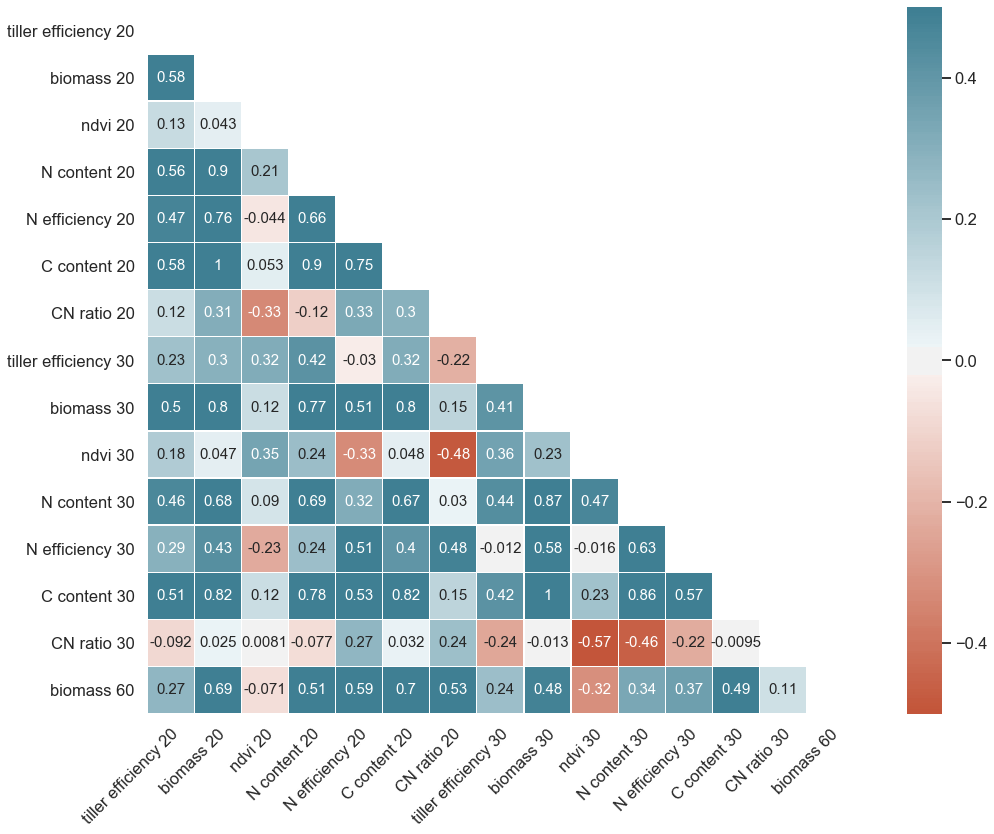

In [47]:
# Plot 1. Biomass:
# Correlation:
corr= matrix.corr()
# Mask for the upper triangle:
mask= np.zeros_like(corr, dtype= np.bool)
mask[np.triu_indices_from(mask)]= True

# heatmap:
f, ax = plt.subplots(figsize=(19, 13))
ax = sns.heatmap(
    corr, 
    mask= mask,
    vmin= -.5, vmax= .5, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    linewidths= .25,
    annot= True,
    square=True,
    annot_kws={"fontsize": 15}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right', 
    rotation_mode= 'anchor'
)
f.savefig("corr_bmass.png",dpi=500)
#f.savefig('bm_correlation.eps', format='eps', dpi=500)

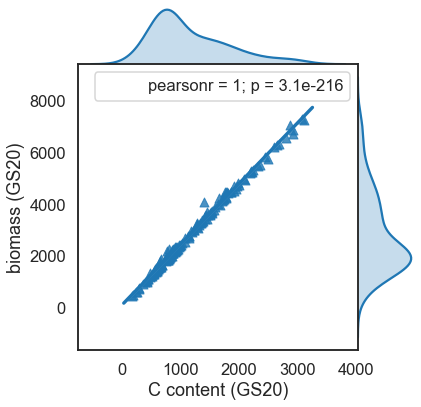

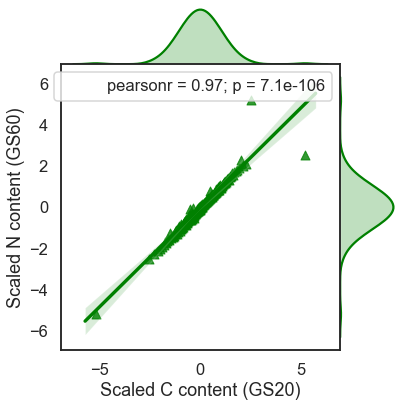

In [26]:
# --------- Figure 4) Transformed and scaled features displaying the highest correlation with the targets
from scipy import stats
sns.set_style("white")
sns.set_context('talk')

g = sns.JointGrid(x='shoot_c_kg_ha_25', 
                  y='biomass_25', 
                  data= full,
                  space=0)
g = g.plot_joint(sns.regplot, marker='^')#cmap="Reds_d")
g = g.plot_marginals(sns.kdeplot,shade= True)
g = g.annotate(stats.pearsonr)
g= g.set_axis_labels('C content (GS20)', 'biomass (GS20)', fontsize=18)

z = sns.JointGrid(x='shoot_c_kg_ha_25', 
                  y='biomass_25', 
                  data= X,
                  space=0)
z = z.plot_joint(sns.regplot, color='g', marker='^')#cmap="Reds_d")
z = z.plot_marginals(sns.kdeplot,shade= True, color='g')
z = z.annotate(stats.pearsonr)
z= z.set_axis_labels('Scaled C content (GS20)', 'Scaled N content (GS60)', fontsize=18)

In [27]:
full[cols_25].describe() # ---- USE THIS TO CORECT FOR BAD NUMBERS (NOT TOO MUCH BAD ACTUALLY)

,tiller_eff_25,biomass_25,ndvi_25,shoot_n_kg_ha_25,n_eff_25,shoot_c_kg_ha_25,cn_ratio_25
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2.938456,2838.190317,0.575289,62.382683,0.375039,1167.382850,18.993867
std,0.702024,1534.044291,0.099086,34.439431,0.161311,649.502736,4.333725
min,1.290000,464.803000,0.330000,13.226000,0.082000,185.117000,10.596000
25%,2.511250,1766.716000,0.503250,36.623500,0.257000,685.934000,15.563500
50%,2.850500,2268.120000,0.578000,55.965500,0.338000,918.703500,19.214500
75%,3.425250,3705.841750,0.659250,77.139000,0.474000,1533.651250,21.968000
max,5.111000,7313.264000,0.757000,177.859000,0.909000,3105.850000,28.373000


## Appendix: Plots and figures for supplementary materials

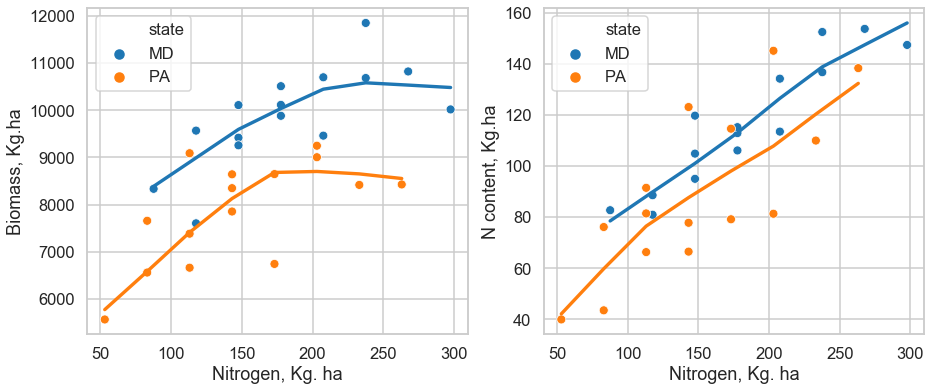

In [28]:
# Appendix 1. Biomass and N content response curves to N (data used for training)
sns.set_style("whitegrid")
sns.set_context('talk')
plt.figure(1, figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(x='total_N',
            y= 'biomass_60_y', 
            hue='state',
            #err_style= 'bars',
            #ci= 68,
            data= bm_N)
sns.regplot(x='total_N',y='biomass_60_y', data=bm_N.query('state == "MD"'), lowess=True, fit_reg=True, scatter=False)
sns.regplot(x='total_N',y='biomass_60_y', data=bm_N.query('state == "PA"'), lowess=True, fit_reg=True, scatter= False)
plt.xlabel('Nitrogen, Kg. ha')
plt.ylabel("Biomass, Kg.ha")
plt.subplot(1,2,2)
sns.scatterplot(x='total_N',
            y= 'shoot_n_kg_ha_60_y', 
            hue='state',
            #err_style= 'bars',
            #ci= 68,
            data= bm_N)
sns.regplot(x='total_N',y='shoot_n_kg_ha_60_y', data=bm_N.query('state == "MD"'), lowess=True, fit_reg=True, scatter= False)
sns.regplot(x='total_N',y='shoot_n_kg_ha_60_y', data=bm_N.query('state == "PA"'), lowess=True, fit_reg=True, scatter= False)
plt.xlabel('Nitrogen, Kg. ha')
plt.ylabel("N content, Kg.ha")
plt.show()

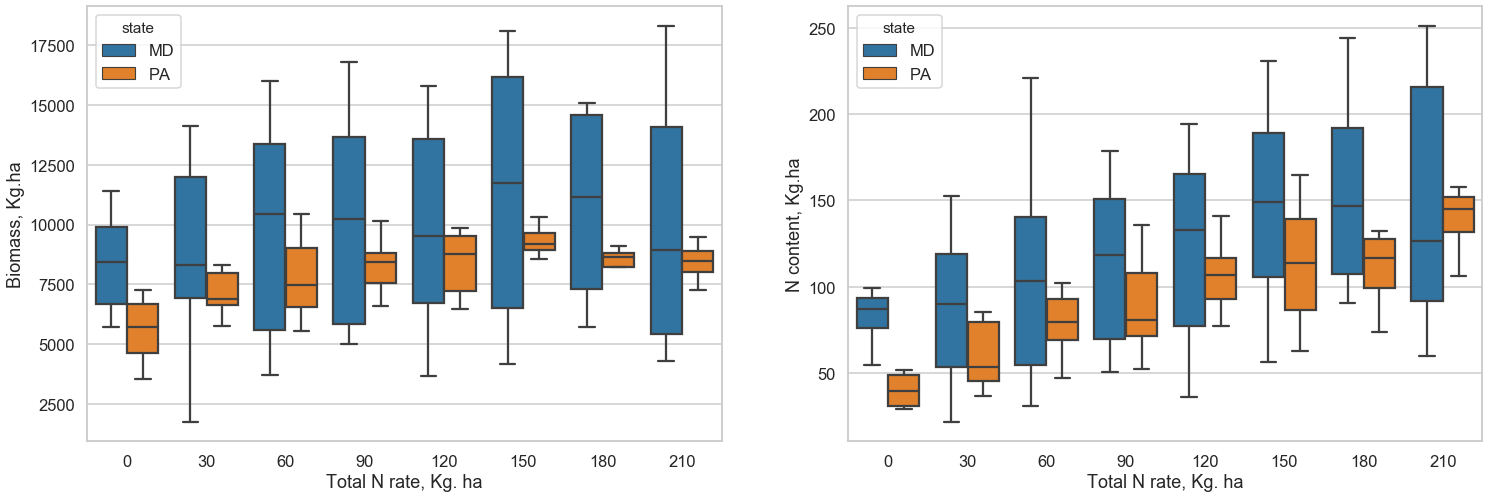

In [54]:
# Appendix 2. Biomass and N content response curves to N (data used for training)
sns.set_style("whitegrid")
sns.set_context('talk')
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
sns.boxplot(x='total_n',
            y= 'biomass_60_y',
            data= full.assign(
                total_n= lambda data: data.n_rate_fall + data.n_rate_spring
            ),
            hue= 'state',
            showfliers= False)
plt.xlabel('Total N rate, Kg. ha')
plt.ylabel("Biomass, Kg.ha")
plt.subplot(1,2,2)
sns.boxplot(x='total_n',
            y= 'shoot_n_kg_ha_60_y',
            data= full.assign(
                total_n= lambda data: data.n_rate_fall + data.n_rate_spring 
            ),
            hue= 'state',
            showfliers= False)
plt.xlabel('Total N rate, Kg. ha')
plt.ylabel("N content, Kg.ha")
plt.show()